In [4]:
import numpy as np
import latools as la

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
d = la.analyse('tests/test_dir/test_data/')

latools analysis using "DEFAULT" configuration:
  5 Data Files Loaded: 2 standards, 3 samples
  Analytes: Mg24 Mg25 Al27 Ca43 Ca44 Mn55 Sr88 Ba137 Ba138
  Internal Standard: Ca43


(<matplotlib.figure.Figure at 0x7f2b6937f748>,
 <matplotlib.axes._axes.Axes at 0x7f2b693a0c18>)

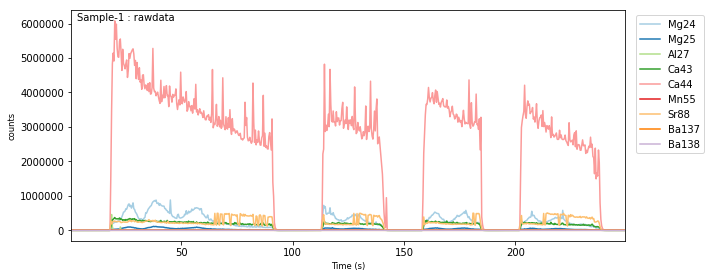

In [6]:
d.data['Sample-1'].tplot(scale=None)

In [7]:
d.despike()

Despiking: 100%|██████████| 5/5 [00:00<00:00, 1052.05it/s]


In [8]:
d.autorange(on_mult=[1.5, 0.8],
            off_mult=[0.8, 1.5])

AutoRange: 100%|██████████| 5/5 [00:00<00:00, 13.87it/s]


In [9]:
d.bkg_calc_weightedmean()

Plotting backgrounds:: 100%|██████████| 9/9 [00:00<00:00, 16.70it/s]


(<matplotlib.figure.Figure at 0x7f2b69028e80>,
 <matplotlib.axes._axes.Axes at 0x7f2b6907c6a0>)

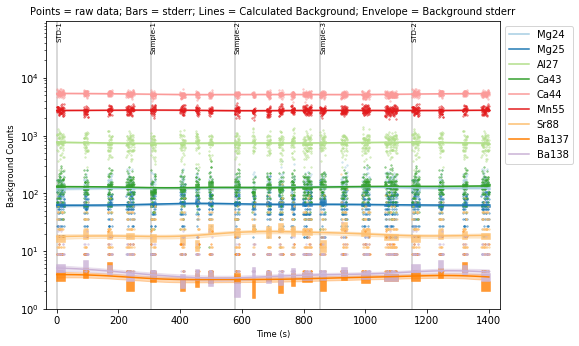

In [10]:
d.bkg_plot()

In [11]:
d.bkg_subtract()

Background Subtraction: 100%|██████████| 5/5 [00:00<00:00, 10.69it/s]


In [12]:
d.get_focus()

In [13]:
d.ratio()

Ratio Calculation: 100%|██████████| 5/5 [00:00<00:00, 29.06it/s]


In [14]:
d.calibrate()

Applying Calibrations: 100%|██████████| 5/5 [00:00<00:00, 11.19it/s]


In [15]:
d.get_focus()

In [16]:
from latools.helpers import bool_2_indices

## Autorange : Deprecated section

In [17]:
def autorange(self, analyte=None, gwin=11, win=40, smwin=5,
                  conf=0.01, on_mult=[1., 1.], off_mult=None, d_mult=1.2,
                  transform='log', bkg_thresh=None, ploterrs=True):


        # remove any background regions that contain internal_standard concs above bkg_thresh
        if bkg_thresh is not None:
            self.bkg[self.focus[self.internal_standard] > bkg_thresh] = False
            self.mkrngs()



        return

## Despiking

In [9]:
from latools.D_obj import cb

In [12]:
cb.get_map('Paired', 'qualitative', 15).hex_colors

ValueError: Invalid number for map type 'Qualitative' and name 'Paired'.
Valid numbers are : [3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [387]:
np.random.seed(6)
osig = np.random.normal(1000, 10, 500)
n = 15
osig[np.random.randint(0,499,n)] = np.random.uniform(0,2500,n)

In [81]:

# dsig, rm = noise_despike(sig, 3)
# print(rm)

# plt.plot(di.Time, sig)
# plt.plot(di.Time, dsig)

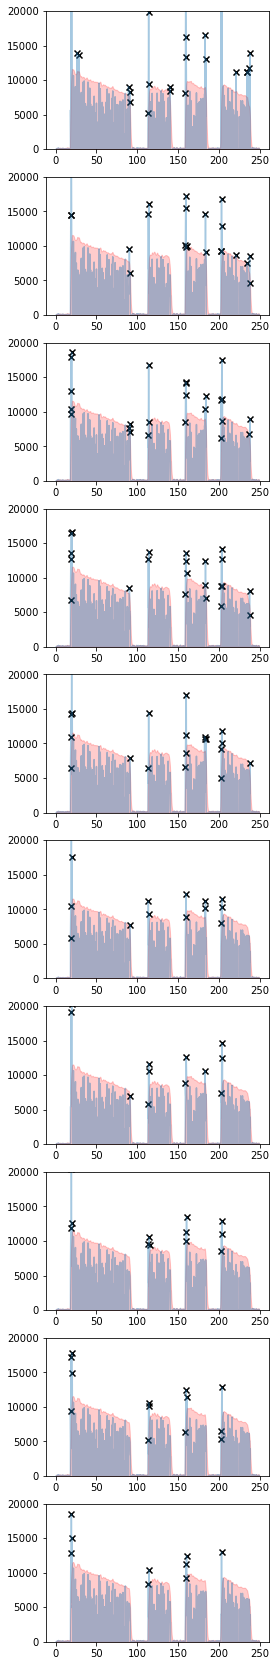

In [122]:
di = d.data_dict['Sample-1']
sig = di.focus['Ca43']

win = 3
maxiter = 10
nlim = 12.

if win % 2 != 1:
    win += 1  # win must be odd

sig = sig.copy()  # copy signal
kernel = np.ones(win) / win  # make convolution kernel
over = np.ones(len(sig), dtype=bool)  # initialize bool array
# pad edges to avoid edge-effects
npad = int((win - 1) / 2)
over[:npad] = False
over[-npad:] = False
# set up monitoring
totrm = 0
nloops = 0
# do the despiking

fig, axs = plt.subplots(maxiter, 1, figsize=(4, 3 * maxiter))
t = di.Time[npad:-npad]

while any(over) and (nloops < maxiter):
    rmean = np.convolve(sig, kernel, 'valid')  # mean by convolution
    rstd = rmean**0.5  # std = sqrt(signal), because count statistics
    # identify where signal > mean + std * nlim (OR signa < mean - std * nlim)
    over[npad:-npad] = sig[npad:-npad] > (rmean + nlim * rstd)  # | (sig[npad:-npad] < rmean - nlim * rstd)
    
    axs[nloops].plot(t, sig[npad:-npad] - rmean, alpha=0.4)
    axs[nloops].fill_between(t,nlim * rstd, color='r', alpha=0.2)
    axs[nloops].set_ylim(0, 20000)
    axs[nloops].scatter(t[over[npad:-npad]], (sig[npad:-npad] - rmean)[over[npad:-npad]], c='k', marker='x', zorder=2)
    
    # if any are over, replace them with mean
    if any(over):
        sig[npad:-npad][over[npad:-npad]] = rmean[over[npad:-npad]]
        totrm += sum(over)
        nloops += 1
        
    # repeat until no more removed.
# return sig, totrm


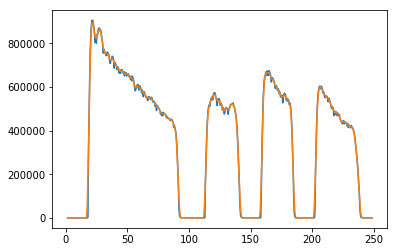

In [118]:
plt.plot(t, sig[npad:-npad])
plt.plot(t, rmean)
# plt.fill_between(t,nlim * rstd, color='r', alpha=0.2)
# plt.plot(di.Time[npad:-npad], rmean)
# plt.plot(di.Time[npad:-npad], rmean + rstd * nlim)

# ind = (sig[npad:-npad] - rmean) > (rstd * nlim)
# plt.scatter(t[ind], (sig[npad:-npad] - rmean)[ind], c='k', marker='x')

# plt.ylim(0, 20000)
# plt.xlim(20,80)
# plt.yscale('log')

(0, 20000)

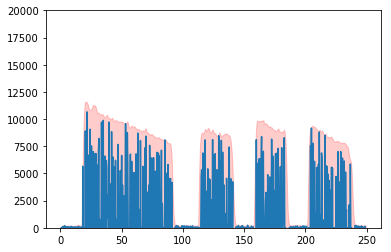

In [97]:
plt.plot(t, sig[npad:-npad] - rmean)
plt.fill_between(t,nlim * rstd, color='r', alpha=0.2)
# plt.plot(di.Time[npad:-npad], rmean)
# plt.plot(di.Time[npad:-npad], rmean + rstd * nlim)

ind = (sig[npad:-npad] - rmean) > (rstd * nlim)
plt.scatter(t[ind], (sig[npad:-npad] - rmean)[ind], c='k', marker='x')

plt.ylim(0, 20000)
# plt.xlim(20,80)
# plt.yscale('log')

In [91]:
sum(ind)

0

In [12]:
tstep = 0.4
expdecay_coef = -1.9

def expdecay_despike(sig, expdecay_coef, tstep, maxloop=5):
    """
    Apply exponential decay filter to remove unrealistically low values.

    Parameters
    ----------
    exponent : float
        Exponent used in filter
    tstep : float
        The time increment between data points.
    maxloop : int
        The maximum number of iterations to
        apply the filter

    Returns
    -------
    None
    """
    sig = sig.copy()

    lo = np.ones(len(sig), dtype=bool)
    hi = np.ones(len(sig), dtype=bool)
    
    nloop = 0
    while any(lo) and (nloop <= maxloop):
        lo = sig < np.roll(sig * np.exp(expdecay_coef * tstep), 1)
        if any(lo):
            prev = sig[np.roll(lo, -1)]
            sig[lo] = prev
            nloop += 1
    
    if nloop < maxloop:
        print(nloop)
        return sig
    else:
        raise ValueError(('\n***maxloop ({}) exceeded during expdecay_despike***\n\n'.format(maxloop) +
                          'This is probably because the expdecay_coef is too small.\n'))

In [397]:
esig = expdecay_despiker(osig, -1.95, 0.4)

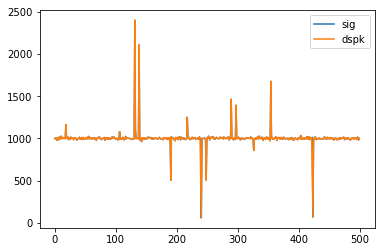

In [398]:
plt.plot(osig, label='sig')
# plt.plot(lod, label='lo')
# plt.plot(hi, label='hi')
plt.plot(esig, label='dspk')

plt.legend()


# plt.xlim(220,260)

In [197]:
dsig = noise_despike(sig, 3)

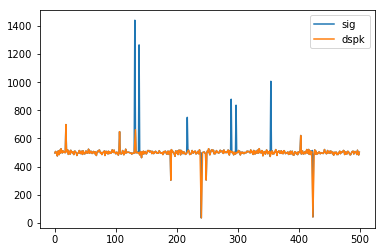

In [198]:
plt.plot(osig, label='sig')
plt.plot(dsig, label='dspk', alpha=1)
# plt.plot(dsig, label='dspk')
# plt.plot(sigmean, label='rmean')
# plt.plot(sigmean + nlim * sigstd, label='lim')

# plt.scatter(np.arange(500)[over], sig[over], marker='x', c='k', label='rm')
plt.legend()
# plt.xlim(150, 300)

## Data Import

In [4]:
import re
import os
import numpy as np
from latools.helpers import Bunch

In [5]:
dataformat = {'genfromtext_args': {'delimiter': ',',
                                   'skip_header': 4},
              'column_id': {'name_row': 3,
                            'delimiter': ',',
                            'timecolumn': 0,
                            'pattern': '([A-z]{1,2}[0-9]{1,3})'},
              'meta_regex': {0: (['path'], '(.*)'),
                             2: (['date', 'method'],
                                 '([A-Z][a-z]+ [0-9]+ [0-9]{4}[ ]+[0-9:]+ [amp]+).* ([A-z0-9]+\.m)')}
             }

data_file = 'tests/test_dir/test_data/Sample-1.csv'
name='file_names'

In [11]:
def read_data(data_file, data_format):
    with open(data_file) as f:
        lines = f.readlines()

    if 'meta_regex' in dataformat.keys():
        meta = {}
        for k, v in dataformat['meta_regex'].items():
            out = re.search(v[-1], lines[int(k)]).groups()
            for i in np.arange(len(v[0])):
                meta[v[0][i]] = out[i]

    # sample name
    if name == 'file_names':
        sample = os.path.basename(data_file).split('.')[0]
    elif name == 'metadata_names':
        sample = self.meta['name']
    else:
        sample = 0

    # column and analyte names
    columns = np.array(lines[dataformat['column_id']['name_row']].strip().split(dataformat['column_id']['delimiter']))
    if 'pattern' in dataformat['column_id'].keys():
        pr = re.compile(dataformat['column_id']['pattern'])
        analytes = [pr.match(c).groups()[0] for c in columns if pr.match(c)]

    # do any required pre-formatting
    if 'preformat_replace' in dataformat.keys():
        clean = True
        with open(data_file) as f:
                fbuffer = f.read()
        for k, v in dataformat['preformat_replace'].items():
            fbuffer = re.sub(k, v, fbuffer)
        # dead data
        read_data = np.genfromtxt(BytesIO(fbuffer.encode()),
                                  **dataformat['genfromtext_args']).T
    else:
        # read data
        read_data = np.genfromtxt(data_file,
                                  **dataformat['genfromtext_args']).T

    # data dict
    dind = np.ones(read_data.shape[0], dtype=bool)
    dind[dataformat['column_id']['timecolumn']] = False

    data = Bunch()
    data['Time'] = read_data[dataformat['column_id']['timecolumn']]
    data['rawdata'] = Bunch(zip(analytes, read_data[dind]))
    data['total_counts'] = read_data[dind].sum(0)

    return sample, data, meta

In [12]:
read_data(data_file, dataformat)

('Sample-1',
 {'Time': array([   0.367,    0.724,    1.081,    1.438,    1.795,    2.152,
            2.509,    2.866,    3.223,    3.58 ,    3.937,    4.294,
            4.65 ,    5.009,    5.366,    5.723,    6.08 ,    6.437,
            6.794,    7.151,    7.508,    7.865,    8.222,    8.579,
            8.936,    9.293,    9.65 ,   10.007,   10.364,   10.721,
           11.078,   11.434,   11.792,   12.149,   12.506,   12.863,
           13.22 ,   13.577,   13.934,   14.291,   14.648,   15.005,
           15.362,   15.719,   16.076,   16.433,   16.791,   17.148,
           17.505,   17.862,   18.218,   18.576,   18.933,   19.29 ,
           19.647,   20.004,   20.361,   20.718,   21.075,   21.432,
           21.789,   22.146,   22.503,   22.86 ,   23.217,   23.574,
           23.931,   24.288,   24.645,   25.002,   25.359,   25.716,
           26.073,   26.43 ,   26.787,   27.144,   27.501,   27.858,
           28.216,   28.573,   28.93 ,   29.287,   29.644,   30.001,
           30

In [ ]:
def __init__(self, data_file, dataformat=None, errorhunt=False, cmap=None, internal_standard='Ca43', name='file_names'):
    if errorhunt:
        # errorhunt prints each csv file name before it tries to load it,
        # so you can tell which file is failing to load.
        print(data_file)
    params = locals()
    del(params['self'])
    self.log = ['__init__ :: args=() kwargs={}'.format(str(params))]

    self.file = data_file
    self.internal_standard = internal_standard

    with open(data_file) as f:
        lines = f.readlines()

    # read the metadata, using key, regex pairs in the line - numbered
    # dataformat['meta_regex'] dict.
    # metadata
    if 'meta_regex' in dataformat.keys():
        self.meta = {}
        for k, v in dataformat['meta_regex'].items():
            out = re.search(v[-1], lines[int(k)]).groups()
            for i in np.arange(len(v[0])):
                self.meta[v[0][i]] = out[i]

    # sample name
    if name == 'file_names':
        self.sample = os.path.basename(self.file).split('.')[0]
    elif name == 'metadata_names':
        self.sample = self.meta['name']
    else:
        self.sample = 0

    # column names
    columns = np.array(lines[dataformat['column_id']['name_row']].strip().split(dataformat['column_id']['delimiter']))
    if 'pattern' in dataformat['column_id'].keys():
        pr = re.compile(dataformat['column_id']['pattern'])
        columns = [pr.match(c).groups()[0] for c in columns if pr.match(c)]
    self.analytes = np.array(columns)

    columns = np.insert(columns, dataformat['column_id']['timecolumn'], 'Time')

    # do any required pre-formatting
    if 'preformat_replace' in dataformat.keys():
        clean = True
        with open(data_file) as f:
                fbuffer = f.read()
        for k, v in dataformat['preformat_replace'].items():
            fbuffer = re.sub(k, v, fbuffer)

        read_data = np.genfromtxt(BytesIO(fbuffer.encode()),
                                  **dataformat['genfromtext_args']).T

    else:
        read_data = np.genfromtxt(data_file,
                                  **dataformat['genfromtext_args']).T

    # create data dict
    self.data = {}
    self.data['rawdata'] = dict(zip(columns, read_data))
    self.data['total_counts'] = read_data.sum(0)

    # set focus to rawdata
    self.setfocus('rawdata')

    # make a colourmap for plotting
    try:
        self.cmap = dict(zip(self.analytes,
                             cb.get_map('Paired', 'qualitative',
                                        len(columns)).hex_colors))
    except:
        self.cmap = \
            dict(zip(self.analytes,
                     [mpl.colors.rgb2hex(c) for c
                      in plt.cm.Dark2(np.linspace(0, 1,
                                                  len(self.analytes)))]))
    # update colourmap with provided values
    if isinstance(cmap, dict):
        for k, v in cmap.items():
            if k in self.cmap.keys():
                self.cmap[k] = v

    # set up flags
    self.sig = np.array([False] * self.Time.size)
    self.bkg = np.array([False] * self.Time.size)
    self.trn = np.array([False] * self.Time.size)
    self.ns = np.zeros(self.Time.size)
    self.bkgrng = np.array([]).reshape(0, 2)
    self.sigrng = np.array([]).reshape(0, 2)

    # set up filtering environment
    self.filt = filt(self.Time.size, self.analytes)

    if errorhunt:
        print('   -> OK')

    return